In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
base_skin_dir = 'data'
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from keras.layers. normalization import BatchNormalization
import keras
from keras.utils.np_utils import to_categorical

from PIL import Image

Using TensorFlow backend.


In [3]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [5]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df = tile_df.sample(6000)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df['localization'] = pd.Categorical(tile_df['localization']).codes
tile_df['sex'] = pd.Categorical(tile_df['sex']).codes

In [6]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,cell_type_idx
5531,HAM_0000537,ISIC_0027095,nv,follow_up,50.0,1,9,Melanocytic nevi,4
9818,HAM_0005924,ISIC_0030953,akiec,histo,80.0,0,14,Actinic keratoses,0
6510,HAM_0001829,ISIC_0027779,nv,follow_up,70.0,1,0,Melanocytic nevi,4
2555,HAM_0005530,ISIC_0029899,bcc,histo,50.0,0,3,Basal cell carcinoma,1
4160,HAM_0004464,ISIC_0025720,nv,follow_up,40.0,1,9,Melanocytic nevi,4


In [27]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type,image
count,5000,5000,5000,5000,5000,5000,5000,5000,5000
unique,4295,5000,7,4,3,15,5000,7,5000
top,HAM_0003789,ISIC_0032757,nv,histo,male,back,data/HAM10000_images_part_2/ISIC_0032948.jpg,Melanocytic nevi,"[[[227, 135, 140], [225, 135, 137], [230, 139,..."
freq,4,1,3342,2636,2691,1078,1,3342,1


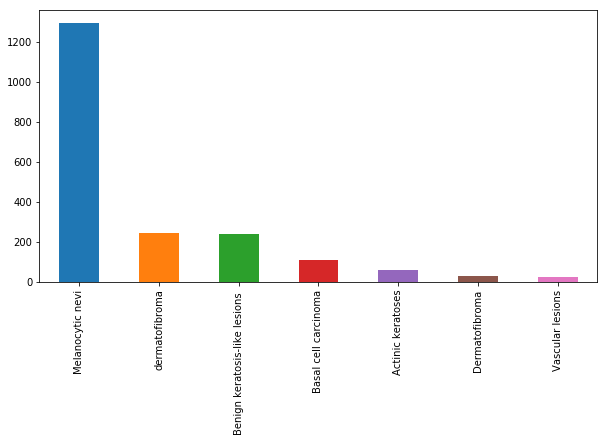

In [5]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


In [5]:
y = tile_df.cell_type_idx

from sklearn.model_selection import train_test_split
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(tile_df, y, test_size=0.25, random_state = 42)

x_train_add = np.asarray([x_train_o['localization'], x_train_o['sex']])
x_test_add = np.asarray([x_test_o['localization'], x_test_o['sex']])

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [26]:
### top_aux_model takes the vectorized text as input
top_aux_model = Sequential()
top_aux_model.add(Dense(vec_size, input_shape=(vec_size,), name='aux_input'))

In [6]:
model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation='relu', input_shape=(90, 120,  3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(96, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(7, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 88, 118, 32)       896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 59, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 59, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 57, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 28, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 21, 28, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 19, 26, 96)        55392     
__________

In [7]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

batch_size = 250 # Todo: experiment with this variable more
epochs = 10

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3750/3750 [==============================] - 65s 17ms/step - loss: 1.2490 - acc: 0.5957 - val_loss: 0.8869 - val_acc: 0.6680
Epoch 2/10
3750/3750 [==============================] - 55s 15ms/step - loss: 0.8978 - acc: 0.6835 - val_loss: 0.7419 - val_acc: 0.7224
Epoch 3/10
3750/3750 [==============================] - 55s 15ms/step - loss: 0.8224 - acc: 0.7085 - val_loss: 0.7784 - val_acc: 0.7176
Epoch 4/10
3750/3750 [==============================] - 58s 15ms/step - loss: 0.7419 - acc: 0.7325 - val_loss: 0.7257 - val_acc: 0.7280
Epoch 5/10
3750/3750 [==============================] - 57s 15ms/step - loss: 0.6962 - acc: 0.7443 - val_loss: 0.7418 - val_acc: 0.7184
Epoch 6/10
3750/3750 [==============================] - 58s 16ms/step - loss: 0.6684 - acc: 0.7531 - val_loss: 0.7008 - val_acc: 0.7472
Epoch 7/10
3750/3750 [==============================] - 70s 19ms/step - loss: 0.6394 - acc: 0.7592 - val_loss: 0.7694 - val_acc: 0.7392


/home/efs/anaconda3/envs/csc8635_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
  if __name__ == '__main__':


TypeError: Invalid dimensions for image data

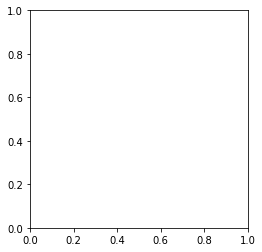

In [34]:
import matplotlib.pyplot as plt
def visualize_incorrect_labels(x_data, y_real, y_predicted):
    # INPUTS
    # x_data      - images
    # y_data      - ground truth labels
    # y_predicted - predicted label
    count = 0
    figure = plt.figure()
    incorrect_label_indices = (y_real != y_predicted)
    y_real = y_real[incorrect_label_indices]
    y_predicted = y_predicted[incorrect_label_indices]
    x_data = x_data[incorrect_label_indices, :, :, :]

    maximum_square = np.ceil(np.sqrt(x_data.shape[0]))

    for i in range(x_data.shape[0]):
        count += 1
        figure.add_subplot(maximum_square, maximum_square, count)
        plt.imshow(x_data[i, :, :, :])
        plt.axis('off')
        plt.title("Predicted: " + str(int(y_predicted[i])) + ", Real: " + str(int(y_real[i])), fontsize=10)

    plt.show()

prediction1 = model.predict(x_test)
prediction1 = np.round(prediction1)

visualize_incorrect_labels(x_test, y_test, np.asarray(prediction1).ravel())

In [33]:
np.asarray(prediction1).ravel()

array([2.4699185e-03, 4.1043689e-03, 1.1727691e-01, ..., 9.5515299e-01,
       3.7329879e-05, 4.4051912e-02], dtype=float32)

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50,
        validation_data=validation_generator,
        validation_steps=800)

In [ ]:
train_batch_size = 64
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch